In [0]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [4]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [0]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [6]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0192 - accuracy: 0.8672 - val_loss: 0.0059 - val_accuracy: 0.9600
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0089 - accuracy: 0.9415 - val_loss: 0.0048 - val_accuracy: 0.9684
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0073 - accuracy: 0.9531 - val_loss: 0.0045 - val_accuracy: 0.9698
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0065 - accuracy: 0.9594 - val_loss: 0.0042 - val_accuracy: 0.9715
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0059 - accuracy: 0.9625 - val_loss: 0.0038 - val_accuracy: 0.9754
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0054 - accuracy: 0.9657 - val_loss: 0.0042 - val_accuracy: 0.9724
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0050 - accuracy: 0.9682 - val_loss: 0.0034 - val_ac

In [7]:
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.003316667163744569, 0.979200005531311]


In [0]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [0]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [0]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [11]:
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.09681949764490128, 0.40700000524520874]


In [12]:
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 0.0054 - accuracy: 0.9700 - val_loss: 0.0101 - val_accuracy: 0.9412
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 2.6000e-04 - accuracy: 0.9984 - val_loss: 0.0090 - val_accuracy: 0.9482
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 8.2846e-05 - accuracy: 0.9994 - val_loss: 0.0102 - val_accuracy: 0.9414
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 1.5403e-04 - accuracy: 0.9990 - val_loss: 0.0106 - val_accuracy: 0.9387
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 8.3592e-05 - accuracy: 0.9994 - val_loss: 0.0105 - val_accuracy: 0.9389
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 4.3204e-05 - accuracy: 0.9998 - val_loss: 0.0101 - val_accuracy: 0.9416
Epoch 7/10
625/625 [==============================] - 5s 9ms/step - loss: 9.3821e-05 - accuracy: 0.9994 - val_loss: 0.0088 - val

In [13]:
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [5.094310784067131e-16, 1.0]
Defended accuracy on regular images: [0.01575949229300022, 0.9121999740600586]


In [14]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Defended accuracy on adversarial images: [0.053087376058101654, 0.6972000002861023]


In [15]:
model.fit(x_adversarial_test, y_adversarial_test,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0024 - accuracy: 0.9860 - val_loss: 0.0215 - val_accuracy: 0.8847
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 2.1823e-04 - accuracy: 0.9987 - val_loss: 0.0148 - val_accuracy: 0.9205
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 1.1075e-04 - accuracy: 0.9992 - val_loss: 0.0159 - val_accuracy: 0.9144
Epoch 4/10
313/313 [==============================] - 3s 10ms/step - loss: 8.4104e-05 - accuracy: 0.9995 - val_loss: 0.0158 - val_accuracy: 0.9146
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 9.9219e-05 - accuracy: 0.9995 - val_loss: 0.0164 - val_accuracy: 0.9119
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 1.5726e-04 - accuracy: 0.9992 - val_loss: 0.0144 - val_accuracy: 0.9222
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 6.9166e-05 - accuracy: 0.9996 - val_loss: 0.015

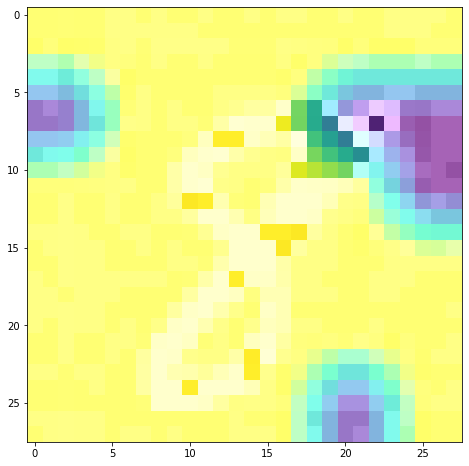

In [44]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

explainer = OcclusionSensitivity()
#img_inp = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img_inp=x_adversarial_test[0]
img_inp = tf.keras.preprocessing.image.img_to_array(img_inp)
grid = explainer.explain(([img_inp], None), model, 5, 5)
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid)

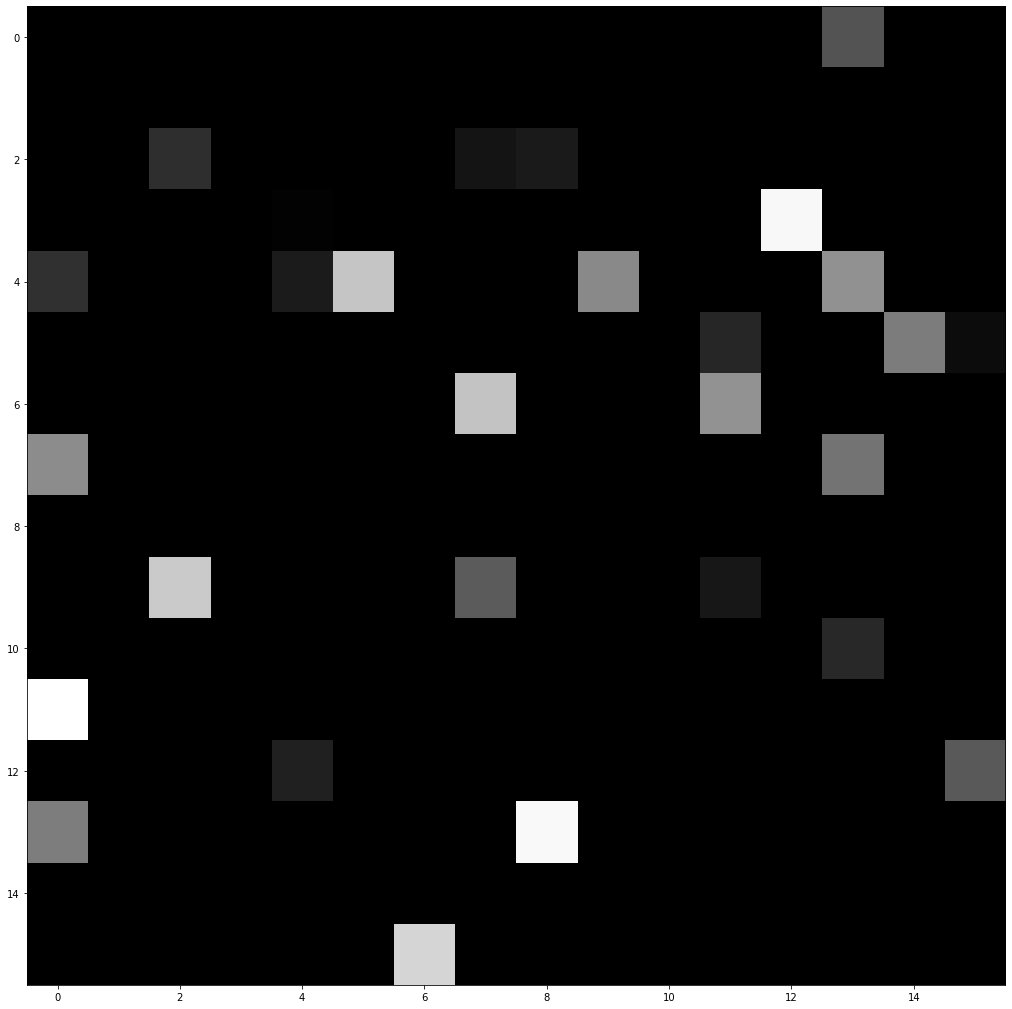

In [62]:
from tf_explain.core.activations import ExtractActivations

explainer = ExtractActivations()
grid = explainer.explain((np.array([img_inp]), None), model, ['conv2d_2'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [30]:
pip install tf-explain

     |████████████████████████████████| 51kB 2.4MB/s 
